# Learning Chernoff Faces



[Chernoff faces](https://en.wikipedia.org/wiki/Chernoff_face) are a creative way to visualize individual elements of multidimensional data. For example, a Chernoff face may be a cartoon face where one dimension of the data point determines the angle of the eyebrows and another determines the size of the eyes. Data points that are very different can produce very different faces and data points that are very similar produce similar faces.

<center>
<table>
<tr>
    <td><img style='height: 160px' src="images/2019-11-06-chernoff-1.png"></td>
    <td><img style='height: 160px' src="images/2019-11-06-chernoff-2.png"></td>
    <td><img style='height: 160px' src="images/2019-11-06-chernoff-1.png"></td>
</tr>
</table>
</center>

The Chernoff faces make it easy for a human to notice patterns in smaller numbers of examples.
Also I think Chernoff Faces are delightful and a little silly, which makes working with them a fun project.

### Learning Chernoff faces and using them on embeddings

Producing Chernoff Faces requires a function that transforms a vector into a face.
In this post, I'll use an autoencoder to learn a function.  And to test them out, I'll convert my [embeddings of library book subjects from a previous post](https://jessicastringham.net/2018/05/16/library-catalog-subject/) into faces.

<center>
<img style='height: 160px' src="images/2018-05-16-ex.png">
</center>

## Training data

For the dataset, I used the labels from the [Helen dataset, which includes annotated pictures of faces](http://www.ifp.illinois.edu/~vuongle2/helen/).
Faces are represented by 194 coordinates that each correspond to a specific point of the face. For example, point 114 is the inner corner of the right eye.

In [46]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap


SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

In [51]:
# hiding this code block in blog post

data_dir = 'data/face_annotation'

img_shape = (194, 2)

# Load the annotations dataset
data = []
for filename in os.listdir(data_dir):
    path = os.path.join(data_dir, filename)
    with open(path) as f:
        data.append([
            [float(y.strip()) for y in x.split(',')] 
            for x in f.readlines()[1:]
        ])
result = np.array(data)

# Normalize the data
data_aligned = result - result.min(axis=1).reshape(result.shape[0], 1, result.shape[2])
data_scale = (result[:, :, 0].max(axis=1) - result[:, :, 0].min(axis=1)).reshape(-1, 1, 1)
data = data_aligned/data_scale
data = data - (data.max(axis=(0, 1))/2).reshape(1, 1, 2)

# Logic for drawing faces from the data
face_components = [
    # chin
    {
        'slice_start': 0,
        'slice_end': 41,
        'closed': False,
    },
    # nose
    {
        'slice_start': 41,
        'slice_end': 58,
        'closed': False,
    },
    # lips
    #{
    #    'slice_start': 58,
    #    'slice_end': 86,
    #    'closed': True,
    #},
    # mouth
    {
        'slice_start': 86,
        'slice_end': 114,
        'closed': True,
    },
    # right_eye
    {
        'slice_start': 114,
        'slice_end': 134,
        'closed': True,
    },
    # left_eye
    {
        'slice_start': 134,
        'slice_end': 154,
        'closed': True,
    },
    # right_eyebrow
    {
        'slice_start': 154,
        'slice_end': 174,
        'closed': True,
    },
    # left_eyebrow
    {
        'slice_start': 174,
        'slice_end': 194,
        'closed': True,
    },
]

def draw_face(ax, d):
    draw_line = lambda start, end: ax.plot(*d[start:end].T, '-k')
    
    def draw_closed_line(start, end): 
        closed_shape = np.vstack([d[start:end], d[start].reshape(1, 2)])
        ax.plot(*closed_shape.T, '-k')
    
    for component in face_components:
        draw_func = draw_closed_line if component['closed'] else draw_line
        draw_func(component['slice_start'], component['slice_end'])

    ax.axis('equal')
    ax.invert_yaxis()
    ax.axis('off')  
    
def random_choice_from_array(array, number):
    return array[np.random.choice(array.shape[0], number, replace=False)]

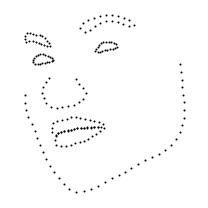

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

random_sample = random_choice_from_array(data, 1)

ax.plot(*random_sample.T, '.k', markersize=2)
ax.axis('equal')
ax.invert_yaxis()
ax.axis('off')  

maybe_save_plot('2019-11-06-dataset-examples-points')

To draw the faces, I connect some of the points. Below is a sample from the dataset.

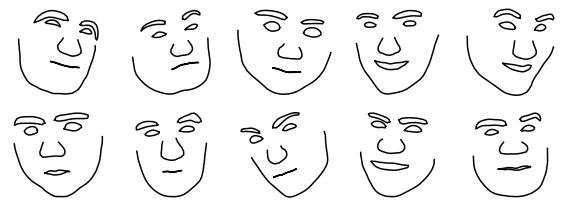

In [194]:
fig, axs = plt.subplots(2, 5, figsize=(8, 3))
axs = axs.flatten()

random_sample = random_choice_from_array(data, len(axs))

for ax, d in zip(axs, random_sample):
    draw_face(ax, d)

maybe_save_plot('2019-11-06-dataset-examples')

## Model

I'll use a simple autoencoder to learn how to convert a multidimensional vector into a face. Specifically, the autoencoder will take the values that represent the face, learns an 'encoder' to map it onto 16 dimensions and a 'decoder' to map it back to the values representing the face. I optimize the network for trying to recreate the same face I pass in.

<center>
<img style="height: 200px" src="images/2019-11-06-autoencoder-diagram.png">
</center>

To learn the faces decoder, I was happy with the results produced using a very simple network defined in Keras below. I use one layer with a sigmoid activation function for the encoder and one layer for the decoder.

In [4]:
import keras
from keras.layers import Dense, Reshape, Flatten, Input
from keras.models import Model, Sequential

latent_dims = 16
img_shape = data[0].shape

img = Input(img_shape, name='img')
encoder = Sequential(name='encoder')
encoder.add(Flatten(name='encoder_flatten'))
encoder.add(Dense(latent_dims, activation='sigmoid', name='encoder_dense'))
encoder.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

decoder = Sequential(name='decoder')
decoder.add(Dense(np.prod(img_shape), name='decoder_dense'))
decoder.add(Reshape(img_shape, name='decoder_reshape'))
decoder.compile(loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

full = Model(img, decoder(encoder(img)), name='full')
full.compile(loss='mean_squared_error',
    optimizer='adam',
    metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
full.fit(data, data, epochs=250)

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
2330/2330 [==============================] - 1s 629us/step - loss: 0.0399 - accuracy: 0.8144
Epoch 2/250
2330/2330 [==============================] - 0s 187us/step - loss: 0.0058 - accuracy: 0.9289
Epoch 3/250
2330/2330 [==============================] - 0s 204us/step - loss: 0.0043 - accuracy: 0.9389
Epoch 4/250
2330/2330 [==============================] - 1s 216us/step - loss: 0.0033 - accuracy: 0.9467
Epoch 5/250
2330/2330 [==============================] - 1s 280us/step - loss: 0.0026 - accuracy: 0.9544
Epoch 6/250
2330/2330 [==============================] - 0s 165us/step - loss: 0.0021 - accuracy: 0.9609
Epoch 7/250
2330/2330 [==============================] - 0s 166us/step - loss: 0.0016 - accuracy: 0.9658
Epoch 8/250
2330/2330 [==============================] - 0s 141us/step - loss: 0.0013 - accuracy: 0.9685
Epoch 9/250
2330/2330 [==============================] - 0s 154us/step - loss: 0.0011 - accuracy: 0.9697
Epoch 1

2330/2330 [==============================] - 0s 176us/step - loss: 1.7174e-04 - accuracy: 0.9890
Epoch 148/250
2330/2330 [==============================] - 0s 183us/step - loss: 1.7241e-04 - accuracy: 0.9890
Epoch 149/250
2330/2330 [==============================] - 0s 162us/step - loss: 1.7228e-04 - accuracy: 0.9890
Epoch 150/250
2330/2330 [==============================] - 0s 145us/step - loss: 1.7102e-04 - accuracy: 0.9889
Epoch 151/250
2330/2330 [==============================] - 0s 213us/step - loss: 1.7238e-04 - accuracy: 0.9890
Epoch 152/250
2330/2330 [==============================] - 0s 160us/step - loss: 1.6984e-04 - accuracy: 0.9889
Epoch 153/250
2330/2330 [==============================] - 0s 156us/step - loss: 1.7018e-04 - accuracy: 0.9890
Epoch 154/250
2330/2330 [==============================] - 0s 158us/step - loss: 1.6946e-04 - accuracy: 0.9891
Epoch 155/250
2330/2330 [==============================] - 0s 153us/step - loss: 1.7076e-04 - accuracy: 0.9889
Epoch 156/250
2

## Fun with the autoencoder


In [6]:
encoded_faces = encoder.predict(data)

Next I can test how well the model can encode and decode the faces. In the image below, the top row was input into the model and the bottom row was the corresponding output.

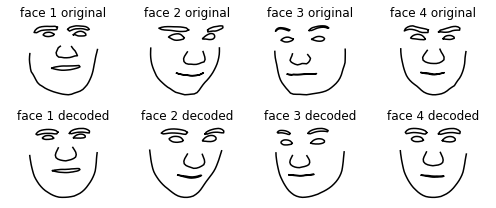

In [195]:
fig, axs = plt.subplots(2, 4, figsize=(7, 3))
axs = axs.T

sample = data[np.random.choice(data.shape[0], data.shape[0], replace=False)]

for i, (ax_row, original) in enumerate(zip(axs, sample)):
    draw_face(ax_row[0], original)
    ax_row[0].set_title('face {} original'.format(i + 1))
    p = full.predict(original.reshape(-1, *img_shape))
    draw_face(ax_row[1], p[0])
    ax_row[1].set_title('face {} decoded'.format(i + 1))

plt.tight_layout()
maybe_save_plot('2019-11-06-autoencoder-example')

The output doesn't match the input exactly. They tend to look more smooth and cartoonish, which is perfect for my use case.

### Perturbing the vector

I can also add a small amount to a face's embedding and see how it affects the output. In this image, the original face is in the center and the two axes correspond to adding values to different dimensions.

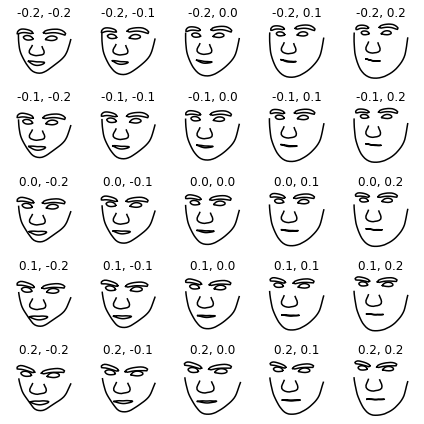

In [200]:
seed = random_choice_from_array(encoded_faces, 1)[0]

dim1 = 0
dim2 = 1

z1 = seed[dim1]
z2 = seed[dim2]

area = 0.2

fig, axs = plt.subplots(5, 5, figsize=(6, 6))

for ax_row, x in zip(axs, np.linspace(-area, area, axs.shape[0])):
    for ax, y in zip(ax_row, np.linspace(-area, area, axs.shape[0])):
        seed[dim1] = x + z1
        seed[dim2] = y + z2            
        line = decoder.predict(np.array([seed]))
        draw_face(ax, line[0].reshape(*img_shape))
        ax.set_title('{:.1f}, {:.1f}'.format(x, y))
        
maybe_save_plot('2019-11-06-face-changing')

One thing this illustrates is that because the decoder is a simple transformation,

$$\text{face}(\textbf{x}) = w_0 + w_1x_1 + \cdots + w_Dx_D,$$

the shape of the face changes linearly too. 

### Interpolation

Alternatively, I can interpolate between two faces. I draw a straight line between the embeddings of the two faces, and then decode points on the line as faces.

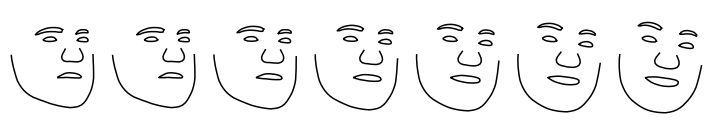

In [201]:
first_face = random_choice_from_array(encoded_faces, 1)[0]
last_face = random_choice_from_array(encoded_faces, 1)[0]

number = 7
fig, axs = plt.subplots(1, number, figsize=(10, 2))

current_face = first_face

for ax, x in zip(axs, np.linspace(0, 1, number)):
    line = decoder.predict(np.array([current_face]))    
    draw_face(ax, line.reshape(*img_shape))
    current_face = first_face + ((last_face - first_face) * x)

maybe_save_plot('2019-11-06-face-interpolate')

## Using Chernoff Faces on Embeddings

Now that I have a decoder that converts a 16-element vector into a face, I can use it to generate drawings based on the [embeddings for subjects of books](https://jessicastringham.net/2018/05/16/library-catalog-subject/).

In that post, I created embeddings using PCA. I reran the notebook to create 16-element vectors of the embeddings.

In [10]:
# hiding this code block in blog post

with open('data/library_catalog_subject_vectors.json') as f:
    subject_vectors = json.load(f)
    subject_lookup = {
        item['subject']: i 
        for i, item in enumerate(subject_vectors)
    }
    raw_catalog_vectors = np.array([
        item['vector']
        for item in subject_vectors
    ])

Since these are 16-element vectors, I could feed them into the decoder as is. That isn't a good idea though, because it's outside of the space that the vector learned to decode. When I do this, it creates art.

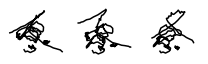

In [206]:
fig, axs = plt.subplots(1, 3, figsize=(3, 1))
axs = axs.flatten()

sample_topics = list(subject_lookup.keys())[:axs.shape[0]]

for ax, topic in zip(axs, sample_topics):
    vec = raw_catalog_vectors[[subject_lookup[topic]]]
    line = decoder.predict(vec)
    draw_face(ax, line.reshape(*img_shape))

maybe_save_plot('2019-11-06-not-fixed')

As a rough way to match the distribution of points, I first encode valid faces to create a target distribution of the face embeddings. Then I assume both the source and target distributions are normally distributed. I scale and move the source distribution (the library subject embeddings) to match the target distribution. For this particular set of source embeddings, it helps to clip the outliers of the source distribution.

In [13]:
def convert_source_dist_to_target_normal(vector_from_source):
    source_stdev = vector_from_source.std(axis=0)
    source_mean = vector_from_source.mean(axis=0)    
    normal_source = (vector_from_source - source_mean)/source_stdev
    # then line up with the new one
    return normal_source * encoded_faces.std(axis=0) + encoded_faces.mean(axis=0)

def convert_source_dist_to_target_clipped_normal(vector_from_source):
    source_stdev = vector_from_source.std(axis=0)
    source_mean = vector_from_source.mean(axis=0)    
    normal_source = (vector_from_source - source_mean)/source_stdev

    # first clip the very big extremes
    # since it's already normalized, just use the number of stdevs
    clip_number_stdevs = 3
    normal_source = np.clip(normal_source, -clip_number_stdevs, clip_number_stdevs)

    # then line up with the new one
    return normal_source * encoded_faces.std(axis=0) + encoded_faces.mean(axis=0)

normal_catalog_vector = convert_source_dist_to_target_normal(raw_catalog_vectors)
catalog_vectors = convert_source_dist_to_target_clipped_normal(raw_catalog_vectors)

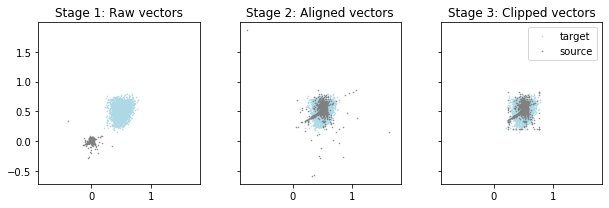

In [205]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

axs[0].plot(encoded_faces[:, 0], encoded_faces[:, 1], '.', color='lightblue', markersize=1, label='target')
axs[0].plot(raw_catalog_vectors[:, 0], raw_catalog_vectors[:, 1], '.', color='gray', markersize=1, label='source')
axs[0].set_title('Stage 1: Raw vectors')
axs[0].axis('square')

axs[1].plot(encoded_faces[:, 0], encoded_faces[:, 1], '.', color='lightblue', markersize=1, label='target')
axs[1].plot(normal_catalog_vector[:, 0], normal_catalog_vector[:, 1], '.', color='gray', markersize=1, label='source')
axs[1].set_title('Stage 2: Aligned vectors')
axs[1].axis('square')

axs[2].plot(encoded_faces[:, 0], encoded_faces[:, 1], '.', color='lightblue', markersize=1, label='target')
axs[2].plot(catalog_vectors[:, 0], catalog_vectors[:, 1], '.', color='gray', markersize=1, label='source')
axs[2].set_title('Stage 3: Clipped vectors')
axs[2].axis('square')

plt.tight_layout()
plt.legend()

maybe_save_plot('2019-11-06-clipping')

### Chernoff faces for subjects related to 'drama'

The following example selects several library catalog subjects that contain the string 'drama'. Then it shows the face generated by the method above that corresponds to the embedding of that subject. It also shows a scatterplot of the first two dimensions of the original embedding, with a black `x` through the subject.

In [189]:
# hiding this code block in blog post

def plot_face_and_vector(axs, topics):
    axs = axs.reshape(-1, 2)

    for ax_row, topic in zip(axs, topics):
        topic_vec = catalog_vectors[subject_lookup[topic]]
        vec = convert_source_dist_to_target_clipped_normal(topic_vec)
        line = decoder.predict(np.array([vec]))[0]

        draw_face(ax_row[0], line.reshape(*img_shape))
        ax_row[0].set_title('\n'.join(wrap(topic, 20)))
        ax_row[1].plot(catalog_vectors[:, 0], catalog_vectors[:, 1], '.', color='lightgray', markersize=2)
        ax_row[1].plot(vec[0], vec[1], 'xk')
        ax_row[1].axis('off')
        ax_row[1].axis('square')        

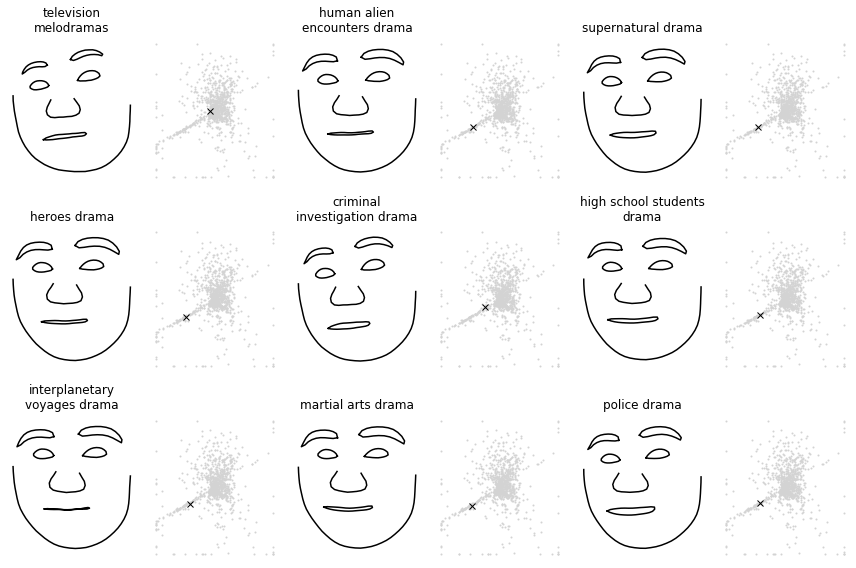

In [166]:
fig, axs = plt.subplots(3, 6, figsize=(12, 8))

filtered_topics = np.array([
    key
    for key in subject_lookup.keys()
    if 'drama' in key
])

topics = random_choice_from_array(filtered_topics, axs.flatten().shape[0]//2)
plot_face_and_vector(axs, topics)
plt.tight_layout()

maybe_save_plot('2019-11-06-ex')

The plot shows a few features of Chernoff faces.
The scatter plot only shows two of the sixteen dimensions, while the face may use many dimensions. The black `x`'s look like they are in the same place for all plots, but the faces show additional differences and similarities. For example, I think "fathers and sons drama" looks more similar to "brothers and sisters drama" than to "human alien encounters drama".
In addition, the face for "television melodrama" looks very different than the others. 

However, there are also some issues. Some elements of the embedding may create outsized differences in the face, while others may result in unnoticeable differences. As it is currently implemented, I don't have control over how much each dimension is used.

### Random subjects

For fun, here's a variety of faces corresponding to a random sample of subjects.

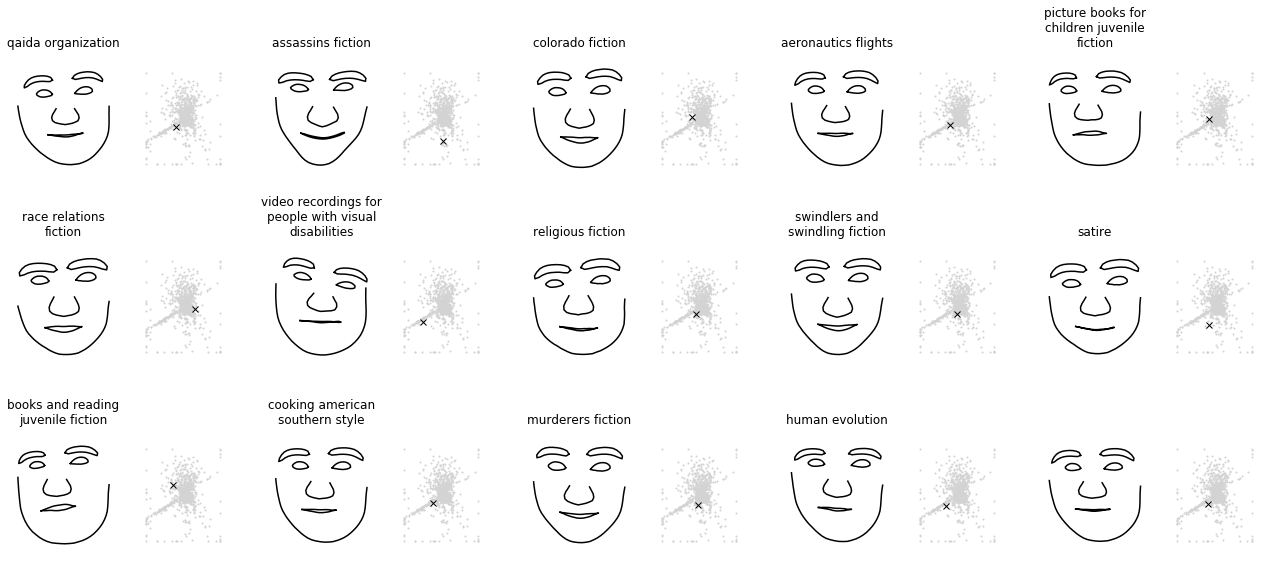

In [207]:
fig, axs = plt.subplots(3, 10, figsize=(18, 8))
axs = axs.flatten()

filtered_topics = np.array(list(subject_lookup.keys()))
topics = random_choice_from_array(filtered_topics, axs.shape[0])
plot_face_and_vector(axs, topics)

maybe_save_plot('2019-11-06-other-faces')

### Attributions and other notes

 - [The dataset comes with the reference:](http://www.ifp.illinois.edu/~vuongle2/helen/) 
> Interactive Facial Feature Localization
Vuong Le, Jonathan Brandt, Zhe Lin, Lubomir Boudev, Thomas S. Huang. 
ECCV2012

 - And thanks for the encouragement, tips, and/or ideas from Simon Ignat, Xinming Wang, and Antreas Antoniou!